In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
data=pd.read_csv("/content/TSLA.csv")
data.head()

Date       Open   High        Low      Close  Adj Close    Volume
0  2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1  2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2  2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
3  2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
4  2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900

In [31]:
def check_df(dataframe,head=5):
    print("#################### Shape #################### ")
    print(dataframe.shape)
    print("#################### Types #################### ")
    print(dataframe.dtypes)
    print("#################### Head #################### ")
    print(dataframe.head(head))
    print("#################### Tail #################### ")
    print(dataframe.dtypes)
    print("#################### NA #################### ")
    print(dataframe.isnull().sum())
    print("#################### Quantiles #################### ")
    print(dataframe.quantile([0,0.5,0.50,0.95,0.99,1]).T)

In [32]:
data["Date"]=pd.to_datetime(data["Date"])         #first execute this before upper cell for no error bcoz we need to change the variable...
data.head()

Date       Open   High        Low      Close  Adj Close    Volume
0 2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1 2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2 2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
3 2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
4 2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900

In [33]:
tesla_data=data[["Date","Close"]]
tesla_data.head()

Date      Close
0 2010-06-29  23.889999
1 2010-06-30  23.830000
2 2010-07-01  21.959999
3 2010-07-02  19.200001
4 2010-07-06  16.110001

In [34]:
print("Min. Tarih:",tesla_data["Date"].min())
print("Max. Tarih:",tesla_data["Date"].max())

Min. Tarih: 2010-06-29 00:00:00
Max. Tarih: 2020-02-03 00:00:00


In [35]:
tesla_data.index=tesla_data["Date"]
tesla_data

Date       Close
Date                             
2010-06-29 2010-06-29   23.889999
2010-06-30 2010-06-30   23.830000
2010-07-01 2010-07-01   21.959999
2010-07-02 2010-07-02   19.200001
2010-07-06 2010-07-06   16.110001
...               ...         ...
2020-01-28 2020-01-28  566.900024
2020-01-29 2020-01-29  580.989990
2020-01-30 2020-01-30  640.809998
2020-01-31 2020-01-31  650.570007
2020-02-03 2020-02-03  780.000000

[2416 rows x 2 columns]

In [36]:
tesla_data.drop("Date",axis=1,inplace=True)
tesla_data

Close
Date                  
2010-06-29   23.889999
2010-06-30   23.830000
2010-07-01   21.959999
2010-07-02   19.200001
2010-07-06   16.110001
...                ...
2020-01-28  566.900024
2020-01-29  580.989990
2020-01-30  640.809998
2020-01-31  650.570007
2020-02-03  780.000000

[2416 rows x 1 columns]

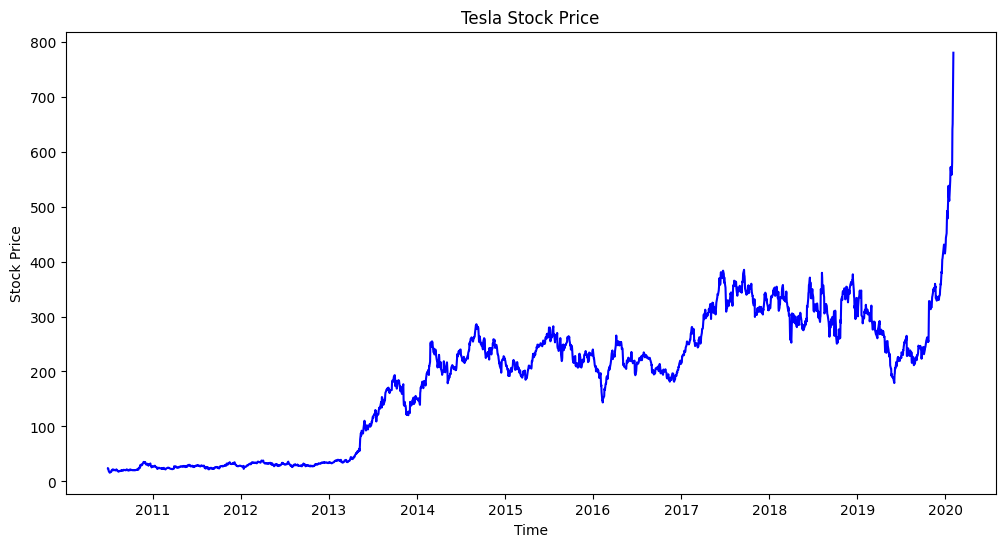

In [37]:
result_data=tesla_data.copy()
plt.figure(figsize=(12,6))
plt.plot(tesla_data["Close"],color="blue");
plt.ylabel("Stock Price")
plt.title("Tesla Stock Price")
plt.xlabel("Time")
plt.show()

In [38]:
tesla_data=tesla_data.values
tesla_data[0:5]

array([[23.889999],
       [23.83    ],
       [21.959999],
       [19.200001],
       [16.110001]])

In [39]:
tesla_data=tesla_data.astype("float32")

In [40]:
def split_data(dataframe,test_size):
    pos=int(round(len(dataframe)*(1-test_size)))
    train=dataframe[:pos]
    test=dataframe[pos:]
    return train,test,pos
train,test,pos=split_data(tesla_data,0.20)
print(train.shape,test.shape)

(1933, 1) (483, 1)


In [41]:
scaler_train=MinMaxScaler(feature_range=(0,1))
train=scaler_train.fit_transform(train)
scaler_test=MinMaxScaler(feature_range=(0,1))
test=scaler_test.fit_transform(test)
train[0:5]

array([[0.02191224],
       [0.02174973],
       [0.01668472],
       [0.0092091 ],
       [0.00083966]], dtype=float32)

In [42]:
test[0:5]

array([[0.25685903],
       [0.24829045],
       [0.25511202],
       [0.24978784],
       [0.2465767 ]], dtype=float32)

In [43]:
def create_features(data,lookback):
    X,Y=[],[]
    for i in range(lookback,len(data)):
        X.append(data[i-lookback:i,0])
        Y.append(data[i,0])
    return np.array(X),np.array(Y)
lookback=20

In [44]:
X_train,y_train=create_features(train,lookback)

In [45]:
X_test,y_test=create_features(test,lookback)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1913, 20) (1913,) (463, 20) (463,)


In [46]:
X_train[0:5]

array([[0.02191224, 0.02174973, 0.01668472, 0.0092091 , 0.00083966,
        0.        , 0.00449621, 0.00433369, 0.0033857 , 0.00633803,
        0.01094258, 0.011078  , 0.01310942, 0.0165493 , 0.01218851,
        0.01197183, 0.01408451, 0.01486999, 0.01394908, 0.01286566],
       [0.02174973, 0.01668472, 0.0092091 , 0.00083966, 0.        ,
        0.00449621, 0.00433369, 0.0033857 , 0.00633803, 0.01094258,
        0.011078  , 0.01310942, 0.0165493 , 0.01218851, 0.01197183,
        0.01408451, 0.01486999, 0.01394908, 0.01286566, 0.01332611],
       [0.01668472, 0.0092091 , 0.00083966, 0.        , 0.00449621,
        0.00433369, 0.0033857 , 0.00633803, 0.01094258, 0.011078  ,
        0.01310942, 0.0165493 , 0.01218851, 0.01197183, 0.01408451,
        0.01486999, 0.01394908, 0.01286566, 0.01332611, 0.01232395],
       [0.0092091 , 0.00083966, 0.        , 0.00449621, 0.00433369,
        0.0033857 , 0.00633803, 0.01094258, 0.011078  , 0.01310942,
        0.0165493 , 0.01218851, 0.01197183, 0

In [47]:
y_test[0:5]

array([0.14734703, 0.1796416 , 0.21088794, 0.20020628, 0.18416718],
      dtype=float32)

In [48]:
X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1913, 1, 20) (1913, 1) (463, 1, 20) (463, 1)


In [49]:
model=Sequential()
model.add(LSTM(units=50,
              activation="relu",
              input_shape=(X_train.shape[1],lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                14200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 14251 (55.67 KB)
Trainable params: 14251 (55.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
model.compile(loss="mean_squared_error",optimizer="adam")
callbacks=[EarlyStopping(monitor="val_loss",patience=3,verbose=1,mode="min"),
          ModelCheckpoint(filepath="mymodel.h5",monitor="val_loss",mode="min",
                         save_best_only=True,save_weights_only=False,verbose=1)]
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=100,
                    batch_size=20,
                    validation_data=(X_test,y_test),
                    callbacks=callbacks,
                    shuffle=False)

Epoch 1/100
82/96 [========================>.....] - ETA: 0s - loss: 0.0068
Epoch 1: val_loss improved from inf to 0.00395, saving model to mymodel.h5
96/96 [==============================] - 2s 6ms/step - loss: 0.0075 - val_loss: 0.0040
Epoch 2/100
87/96 [==========================>...] - ETA: 0s - loss: 0.0048
Epoch 2: val_loss improved from 0.00395 to 0.00286, saving model to mymodel.h5
96/96 [==============================] - 0s 4ms/step - loss: 0.0055 - val_loss: 0.0029
Epoch 3/100
89/96 [==========================>...] - ETA: 0s - loss: 0.0036
Epoch 3: val_loss did not improve from 0.00286
96/96 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 4/100
90/96 [===========================>..] - ETA: 0s - loss: 0.0037
Epoch 4: val_loss improved from 0.00286 to 0.00256, saving model to mymodel.h5
96/96 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 0.0026
Epoch 5/100
89/96 [==========================>...] - ETA: 0s - loss:

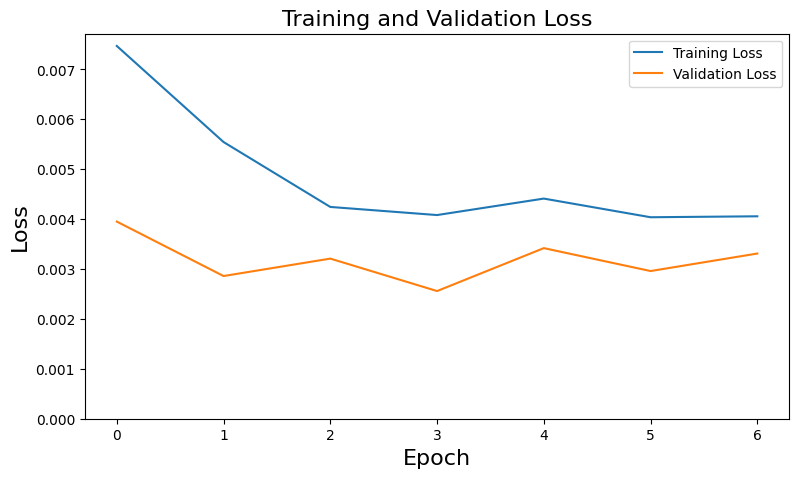

In [52]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title("Training and Validation Loss",fontsize=16)
plt.show()

In [53]:
loss=model.evaluate(X_test,y_test,batch_size=20)

24/24 [==============================] - 0s 2ms/step - loss: 0.0033


In [54]:
print("\nTest loss:%.1f%%"%(100.0*loss))


Test loss:0.3%


In [55]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict=scaler_train.inverse_transform(train_predict)
test_predict=scaler_test.inverse_transform(test_predict)
y_train=scaler_train.inverse_transform(y_train)
y_test=scaler_test.inverse_transform(y_test)

15/15 [==============================] - 0s 2ms/step


In [56]:
train_rmse=np.sqrt(mean_squared_error(y_train,train_predict))
test_rmse=np.sqrt(mean_squared_error(y_test,test_predict,))
print(f"Train RMSE:{train_rmse}")
print(f"Test RMSE:{test_rmse}")

Train RMSE:19.15941047668457
Test RMSE:34.58034133911133


In [57]:
train_prediction_data=result_data[lookback:pos]
train_prediction_data["Predicted"]=train_predict
train_prediction_data.head()

Close  Predicted
Date                            
2010-07-28  20.719999  28.452665
2010-07-29  20.350000  28.422626
2010-07-30  19.940001  28.385883
2010-08-02  20.920000  28.385883
2010-08-03  21.950001  28.385883

In [58]:
test_prediction_data=result_data[pos+lookback:]
test_prediction_data["Predicted"]=test_predict
test_prediction_data.head()

Close   Predicted
Date                              
2018-04-03  267.529999  285.201874
2018-04-04  286.940002  281.849274
2018-04-05  305.720001  279.566864
2018-04-06  299.299988  280.590851
2018-04-09  289.660004  280.791473

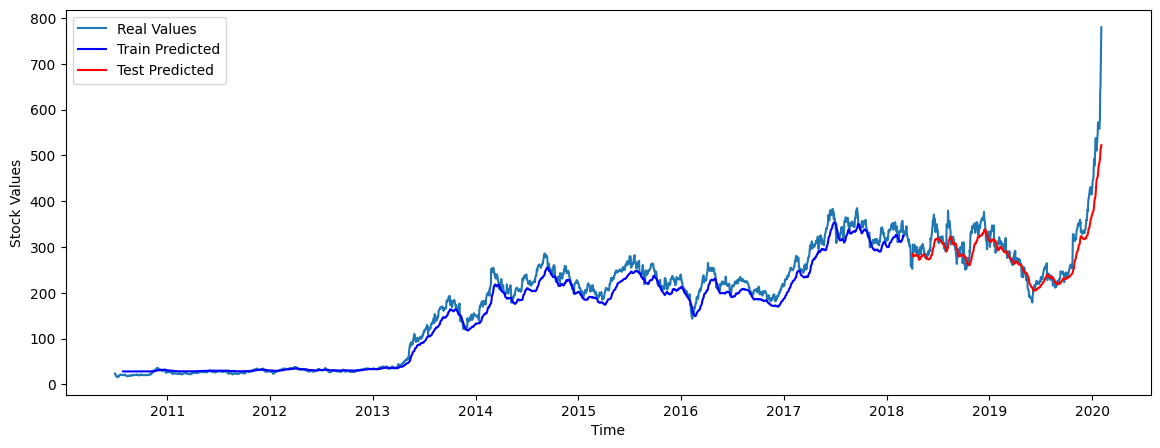

In [59]:
plt.figure(figsize=(14,5))
plt.plot(result_data,label="Real Values")
plt.plot(train_prediction_data["Predicted"],color="blue",label="Train Predicted")
plt.plot(test_prediction_data["Predicted"],color="red",label="Test Predicted")
plt.xlabel("Time")
plt.ylabel("Stock Values")
plt.legend()
plt.show()

project  by     .....afnan khan